In [20]:
%pylab inline
import ee
import geemap
import cartopy.crs as ccrs
import os
ee.Authenticate()

from geemap import cartoee as cee
geemap.ee.Initialize()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [61]:
# https://developers.google.com/earth-engine/datasets/catalog/WRI_GPPD_power_plants
pp = ee.FeatureCollection("WRI/GPPD/power_plants") 
Yangtze = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Yangtze')
Yellow = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Yellow')
SaintLawrence = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/SaintLawrence')
Rhone = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Rhone')
Parana = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Parana')
Nile = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Nile')
Niger = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Niger')
Mississippi = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Mississippi')
Danube = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Danube')
Amazon = ee.FeatureCollection('projects/ee-samuelvalman/assets/P3RT/Amazon')


disToCity = ee.Image("Oxford/MAP/accessibility_to_cities_2015_v1_0") 
urban = ee.Image("DLR/WSF/WSF2015/v1")


# GRWLvar 
river = ee.FeatureCollection("projects/sat-io/open-datasets/GRWL/water_vector_v01_01")




# interactive tests

In [10]:
def makePlot(site, power, background, river):
    
    u = background.clip(site.geometry())
    
    ## outline site 
    outlined_fc = ee.Image().byte().paint(site, 1, 2 ) # 1 is the color (black), 2 is the width of the outline
    vis_params = {'palette': ['000000'],  # Black color
    'opacity': 1.0}
    
    
    fuelColor = { 'Coal': 'e31a1c', # red
                  'Oil': '593704',
                  'Gas': 'bc80bd',
                  'Hydro': '0565A6',
                  'Nuclear': 'FFFF00',
                  'Solar': 'ff7f00',
                  'Waste': '6a3d9a',
                  'Wind': '5ca2d1',
                  'Geothermal': 'fdbf6f',
                  'Biomass': '229a00'}
    fuels = [    'Coal', 'Oil', 'Gas', 'Hydro', 'Nuclear',
    'Solar', 'Waste', 'Wind', 'Geothermal', 'Biomass']
    
    river =  river.map(lambda feature: feature.intersection(site.geometry(), ee.ErrorMargin(1)))

    
    ## create the map:
    Map = geemap.Map()
    Map.addLayer(u, {'palette':'404040'},name='background')

    for fuel in fuels:
        fil = power.filter(ee.Filter.eq('fuel1', fuel)).style(color=fuelColor[fuel])
        Map.addLayer(fil, name=fuel)
    rs = {'color':'0000FF'}
    Map.addLayer(river.style('0565A6')) # 0000FF
    Map.addLayer(outlined_fc, vis_params)
    Map.centerObject(site)
    return Map
    

In [13]:
# m = makePlot(yangtze, pp, urban)
# m = makePlot(Yellow, pp, urban, river)
# m = makePlot(Danube, pp, urban)
# m = makePlot(Rhone, pp, urban)
# m = makePlot(Mississippi, pp, urban)
# m = makePlot(SaintLawrence, pp, urban)
# m = makePlot(Parana, pp, urban)
# m = makePlot(Amazon, pp, urban)
m = makePlot(Nile, pp, urban, river)
# m = makePlot(Niger, pp, urban)


m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Download important aspects for Qgis mapping

In [71]:
def downloadableItems(fc, urban=urban, river=river,pp=pp):
    '''
    fc: feature collection e.g., rhone etc
    urban == urban grey areas
    river == GRWL river
    pp == powerplants
    '''
    r_out =  river.filterBounds(fc.geometry())#river.map(lambda feature: feature.intersection(fc.geometry(), ee.ErrorMargin(1)))
    u_out = urban.clip(fc.geometry())

    p_out = pp.filterBounds(fc.geometry())

    return r_out, u_out, p_out

def downloadThese(r, u, p, riverName):
    '''
    r, u, p are outputs of downloadableItems
    riverName is a str
    '''
    opPath = r'D:\RT_temperaturePrivate\Analysis\Figures\002_RoundTwo\M2_SitePanel\GEEDownloads'
    # make file pats
    rp = riverName + '_river.shp'
    up= riverName + '_urban.tif'
    pp = riverName + '_pp.shp'
    
    rp = os.path.join(opPath, rp)
    up = os.path.join(opPath, up)
    pp = os.path.join(opPath, pp)

    # print(rp)
    # download shape files
    # geemap.ee_export_vector(r, rp)#, fileFormat='shp')
    # geemap.ee_export_vector(p, pp)#, fileFormat='shp')
    geemap.ee_export_image(u, up, scale = 30)
    print('complete for ' + riverName)

In [73]:
r,u,p = downloadableItems(Nile)
downloadThese(r, u, p, 'Nile')
# r,u,p = downloadableItems(Rhone)
# downloadThese(r, u, p, 'Rhone')
# r,u,p = downloadableItems(Yangtze)
# downloadThese(r, u, p, 'Yangtze')

Generating URL ...
Please wait ...
Data downloaded to D:\RT_temperaturePrivate\Analysis\Figures\002_RoundTwo\M2_SitePanel\GEEDownloads\Nile_urban.tif
complete for Nile


In [70]:
Map = geemap.Map()
Map.addLayer(u)
Map.centerObject(u)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [67]:
# if too big go via drive
geemap.ee_export_image_to_drive(u, description='Yangtze_ur', region=Yangtze.geometry(), scale=30)

# Quality maps

In [3]:
# required functions
def getRegion(site):
    bounding_box = site.geometry().bounds().coordinates().getInfo()

    # Extract the coordinates.
    min_lon = bounding_box[0][0][0]
    min_lat = bounding_box[0][0][1]
    max_lon = bounding_box[0][2][0]
    max_lat = bounding_box[0][2][1]
    region = [min_lon-0.01, min_lat-0.01, max_lon+0.01, max_lat+0.01]
    print(region)
    return region


In [21]:
def printableMap(site, power, background, river):
    polygon = ee.Image().byte().paint(site, 1, 2 ) 
    u = background.clip(site.geometry())
    
    river =  river.map(lambda feature: feature.intersection(site.geometry(), ee.ErrorMargin(1)))

    vp = {'palette':'404040'}
    rvp = {'palette':'0000FF'}
    u = u.visualize(**vp)
    image = u.blend(polygon)
    image = image.blend(river.style('0000FF'))
    
    # powerplants
    fuelColor={'Coal': 'e31a1c',# red
              'Nuclear': 'FFFF00',# yellow
               'Gas': 'bc80bd', #purple
               'Oil': 'ff7f00',# orange
               'Biomass':'229a00', # green
               'Hydropower':'0565A6'} # blue
    fuelList = ['Coal', 'Nuclear', 'Gas', 'Oil', 'Biomass', 'Hydropower']
    colors = ['e31a1c', 'FFFF00','bc80bd','ff7f00','229a00','0565A6']
    for f in fuelList:

#         borderColor = 'ffffff'  # Border color (black in this case)
#         borderSize = 7  # Size of the border

#         # Create a secondary layer with larger points for border effect
#         borderFil = power.filter(ee.Filter.eq('fuel1', f)).style(color=borderColor, pointSize=borderSize)
#         image = image.blend(borderFil)
        
        fil = power.filter(ee.Filter.eq('fuel1', f)).style(color=fuelColor[f], pointSize=8)
        image = image.blend(fil)
        
        
    # get region to match site polygon
    region = getRegion(site)
    
    # write figure
    fig = plt.figure()
    ax = plt.subplot()#projection=ccrs.PlateCarree())

#     ax.add_legend(keys=fuelList, colors=fuelColor.values, position="bottomleft")
    
#     legend
    legend = []
    for index, fuel in enumerate(fuelList):
        item = Line2D(
                        [],
                        [],
                        marker="o",
                        color='#' + colors[index],
                        label=fuel,
                        markerfacecolor='#' + colors[index],
                        markersize=5,
                        ls="",
                    )
        legend.append(item)
    
    
    
    cee.add_legend(ax, legend_elements=legend)

    cee.get_map(image, region=region)

#     cee.add_north_arrow(ax, text='N', xy=(0.9, 0.4), arrow_length=0.1, text_color='black', arrow_color='black', fontsize=20, width=5, headwidth=15, ha='center', va='center')
#     cee.add_scale_bar(ax, metric_distance=4, unit='km', at_x=(0.05, 0.5), at_y=(0.08, 0.11), max_stripes=5, ytick_label_margins=0.25, fontsize=8, font_weight='bold', rotation=0, zorder=999, paddings={'xmin': 0.05, 'xmax': 0.05, 'ymin': 1.5, 'ymax': 0.5}, bbox_kwargs={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.5})
    return fig


    
    

[6.593366833291927, 5.740916030028969, 6.799284595600881, 6.6845786289102485]


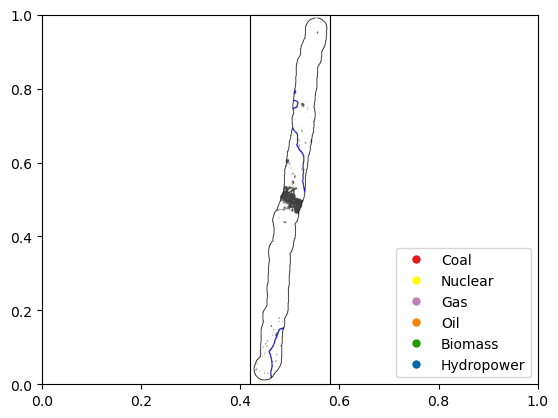

In [22]:
fig = printableMap(Niger, pp, urban, river)
show()

[30.865591577679652, 26.846621652634234, 31.52960168068564, 27.44475743923566]


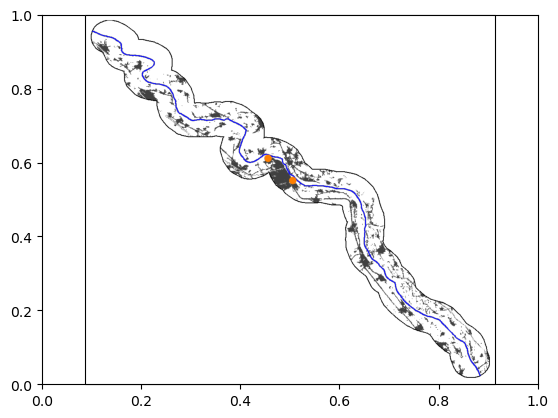

In [75]:
fig = printableMap(Nile, pp, urban, river)
show()

# Test maps

In [41]:
# fil = pp.filter(ee.Filter.eq('fuel1', 'Coal')).style(color='111111')
# # styled_fil = fil.style(color='000000')


# Map = geemap.Map()
# Map.addLayer(fil)
# Map